In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import optuna
from optuna.integration import FastAIPruningCallback
import matplotlib.pyplot as plt

In [27]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GroupKFold
from optiver_features import *

In [28]:
df_train = pd.read_csv('train_with_features_NO_ST.csv')
df_train = df_train.drop(['row_id'], axis=1)

In [29]:
trn_idx, val_idx = first(GroupKFold().split(df_train, groups = df_train.time_id))
splits=[list(trn_idx), list(val_idx)]

In [44]:
def get_dls(splits):
    cont_nn,cat_nn = cont_cat_split(df_train, max_card=9000, dep_var='target')
    cat_nn.remove('time_id')
    procs_nn = [Categorify,FillMissing, Normalize]
    to_nn = TabularPandas(df_train, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target')

    return to_nn.dataloaders(1024)

In [45]:
dls0 = get_dls(splits)

In [46]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'ps':[0,.1,.1,.1,0], 'embed_p':0.05, }
learn = tabular_learner(dls0, y_range=(0,.1), layers=[500,500,500, 200, 100], 
                        n_out=1, loss_func = rmspe, metrics=AccumMetric(rmspe), config=config,wd=0)

In [ ]:
learn.fit_one_cycle(50, 1e-2)

In [53]:
def train_cross_valid(trial):
    res = 0
    for idx, (tnr_idx, val_idx) in enumerate(GroupKFold().split(df_train, groups = df_train.time_id)):
        dls = get_dls([list(trn_idx), list(val_idx)])
        v = train_network(trial, dls, 'tab_{idx}')
        res += v/5
    print('cross valid:', res)
    return res

In [50]:
def train_network(trial, dls, save_as = None):
    n_layers = trial.suggest_int('n_layers',2,5)
    dropouts = []
    layer_sizes = []
    for i in range(n_layers):
        dropouts.append(trial.suggest_float(f'p{i}', 0, 1))
        layer_sizes.append(trial.suggest_int(f'layer_{i}', 10, 1000))
    embed_p = trial.suggest_float('embed_p', 0, 1)
    config = {'ps': dropouts, 'embed_p':embed_p}
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    learn = tabular_learner(dls, y_range=(0,.1), layers=layer_sizes, 
                        n_out=1, loss_func = rmspe, metrics=AccumMetric(rmspe), config=config, cbs=FastAIPruningCallback(trial, monitor="rmspe"))
    #with learn.no_bar():
    #with learn.no_logging():
    learn.fit_one_cycle(50, lr)
    if save_as:
        learn.save(save_as)
    return learn.recorder.metrics[0].value

In [1]:
# pruner = optuna.pruners.MedianPruner(n_warmup_steps=3)
# sampler  =optuna.samplers.CmaEsSampler(warn_independent_sampling=False)
# study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'tabular_learner', storage='sqlite:///optuna.db',
#                             sampler= sampler,load_if_exists=True)

# study.optimize(functools.partial(train_network, dls=dls))

In [40]:
study = optuna.create_study(direction="minimize",  study_name = 'tabular_learner_50_epochs', storage='sqlite:///optuna.db',load_if_exists=True)

[I 2021-09-15 15:34:20,003] Using an existing study with name 'tabular_learner_50_epochs' instead of creating a new one.


In [54]:
train_cross_valid(study.best_trial)

epoch,train_loss,valid_loss,rmspe,time
0,1.098851,0.584027,0.614974,00:04
1,0.504676,0.437571,0.444251,00:05
2,0.264706,0.249233,0.252414,00:04
3,0.262713,0.242929,0.245220,00:04
4,0.265415,0.263402,0.268151,00:04
5,0.275421,0.257617,0.260210,00:04
6,0.264510,0.255039,0.257498,00:04
7,0.287639,0.256453,0.259877,00:04
8,0.256328,0.244023,0.246042,00:04
9,0.256666,0.240820,0.243612,00:04


epoch,train_loss,valid_loss,rmspe,time
0,0.986442,0.426838,0.439711,00:04
1,0.420078,0.324483,0.328635,00:05
2,0.260049,0.250505,0.253379,00:04
3,0.259961,0.250962,0.253921,00:04
4,0.268588,0.253325,0.256855,00:04
5,0.264689,0.259708,0.264696,00:04
6,0.257400,0.418446,1.591766,00:04
7,0.254355,0.240664,0.243648,00:04
8,0.254866,0.245602,0.247640,00:04
9,0.247813,0.247200,0.251041,00:04


epoch,train_loss,valid_loss,rmspe,time
0,1.030955,0.482362,0.507724,00:04
1,0.517725,0.526404,0.563947,00:04
2,0.271860,0.249544,0.252791,00:05
3,0.290149,0.239070,0.244170,00:04
4,0.274795,0.257058,0.260065,00:04
5,0.256666,0.232860,0.235787,00:04
6,0.251692,0.231159,0.233114,00:04
7,0.253108,0.262632,0.384820,00:04
8,0.248413,0.232868,0.234778,00:04
9,0.245995,0.228575,0.232077,00:04


epoch,train_loss,valid_loss,rmspe,time
0,1.021050,0.626287,0.668907,00:04
1,0.457870,0.346684,0.366198,00:04
2,0.269827,0.241204,0.245536,00:04
3,0.263910,0.247692,0.252295,00:04
4,0.261670,0.262872,0.270060,00:04
5,0.259093,0.258690,0.261881,00:04
6,0.272097,0.268608,0.272298,00:04
7,0.253240,0.270075,0.278839,00:04
8,0.257669,0.231416,0.234943,00:04
9,0.246572,0.224693,0.227193,00:04


epoch,train_loss,valid_loss,rmspe,time
0,1.152224,0.396335,0.418566,00:06
1,0.423464,0.271068,0.275983,00:06
2,0.263401,0.234603,0.237223,00:06
3,0.263071,0.268250,0.270732,00:06
4,0.265347,0.251342,0.254239,00:06
5,0.323646,0.295432,0.299444,00:06
6,0.254327,0.233577,0.236346,00:06
7,0.275643,0.240712,0.243125,00:06
8,0.254086,0.228264,0.230171,00:06
9,0.250885,0.234023,0.239550,00:06


cross valid: TensorBase(0.4316)


TensorBase(0.4316)

In [21]:
results = study.trials_dataframe()

In [22]:
results[results.value<.25]

,number,value,datetime_start,datetime_complete,duration,params_embed_p,params_layer_0,params_layer_1,params_layer_2,params_layer_3,params_layer_4,params_lr,params_n_layers,params_p0,params_p1,params_p2,params_p3,params_p4,state
6,6,0.233895,2021-09-14 19:10:17.390967,2021-09-14 19:19:04.956995,0 days 00:08:47.566028,0.342363,860,710,492.0,485.0,452.0,0.001965,5,0.422476,0.323437,0.433001,0.478315,0.061193,COMPLETE
11,11,0.240892,2021-09-14 19:19:05.094274,2021-09-14 19:27:57.948302,0 days 00:08:52.854028,0.161679,605,454,896.0,875.0,624.0,0.013544,5,0.463877,0.423574,0.217758,0.029074,0.009421,COMPLETE
12,12,0.233136,2021-09-14 19:19:13.387732,2021-09-14 19:27:57.709125,0 days 00:08:44.321393,0.012373,147,175,297.0,559.0,333.0,0.004043,5,0.092323,0.467876,0.483218,0.092021,0.342462,COMPLETE
26,26,0.248014,2021-09-14 19:28:47.224922,2021-09-14 19:31:42.681427,0 days 00:02:55.456505,0.264576,687,491,393.0,996.0,643.0,0.005690,5,0.442815,0.357079,0.077706,0.017049,0.013735,PRUNED
30,30,0.231037,2021-09-14 19:30:55.907849,2021-09-14 19:39:50.626817,0 days 00:08:54.718968,0.122004,301,191,378.0,288.0,187.0,0.008197,5,0.217686,0.427615,0.327556,0.105068,0.133441,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,1423,0.229898,2021-09-15 10:05:31.314203,2021-09-15 10:12:35.640217,0 days 00:07:04.326014,0.111557,586,626,189.0,117.0,178.0,0.011011,5,0.060942,0.122342,0.111681,0.114416,0.024568,COMPLETE
1430,1430,0.229580,2021-09-15 10:12:35.753346,2021-09-15 10:19:47.040697,0 days 00:07:11.287351,0.082620,555,653,746.0,201.0,132.0,0.014342,5,0.012169,0.210881,0.357309,0.131722,0.043945,COMPLETE
1433,1433,0.236297,2021-09-15 10:15:12.041609,2021-09-15 10:21:41.248445,0 days 00:06:29.206836,0.084016,568,574,485.0,236.0,149.0,0.018307,5,0.009312,0.061159,0.135031,0.145541,0.045554,PRUNED
1444,1444,0.249178,2021-09-15 10:21:03.117655,2021-09-15 10:22:32.603639,0 days 00:01:29.485984,0.125012,605,505,499.0,230.0,177.0,0.012830,5,0.041662,0.018743,0.101965,0.070840,0.016187,PRUNED


In [24]:
results[results.value == results.value.min()]

,number,value,datetime_start,datetime_complete,duration,params_embed_p,params_layer_0,params_layer_1,params_layer_2,params_layer_3,params_layer_4,params_lr,params_n_layers,params_p0,params_p1,params_p2,params_p3,params_p4,state
1217,1217,0.228542,2021-09-15 08:05:55.633072,2021-09-15 08:14:39.466266,0 days 00:08:43.833194,0.061184,555,600,717.0,216.0,152.0,0.013004,5,0.046188,0.038822,0.127456,0.071812,0.024377,COMPLETE


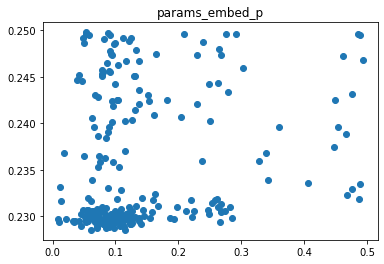

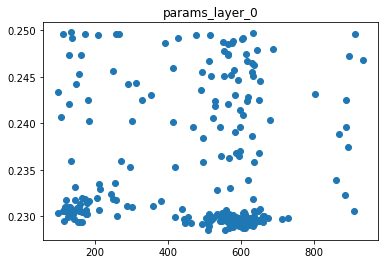

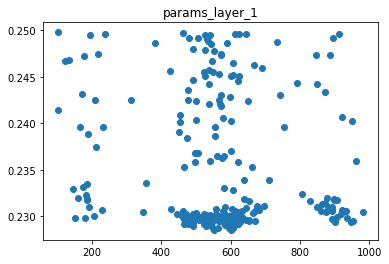

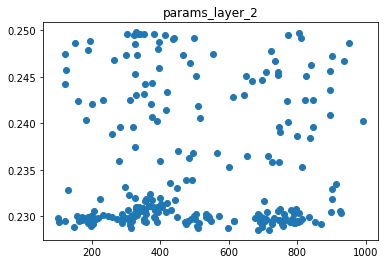

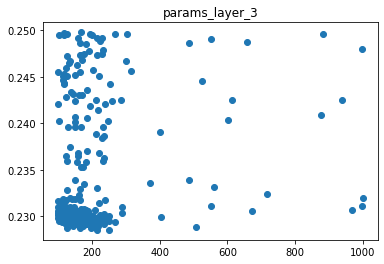

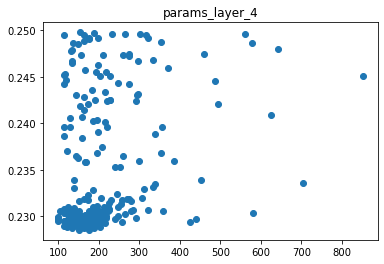

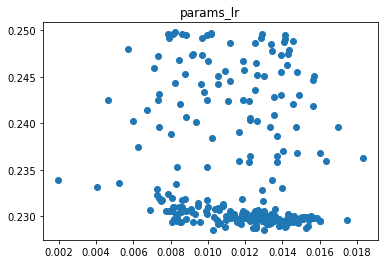

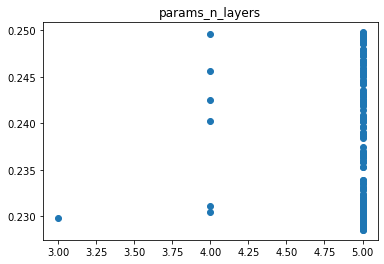

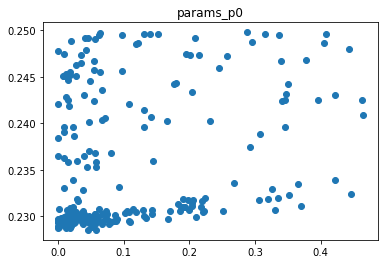

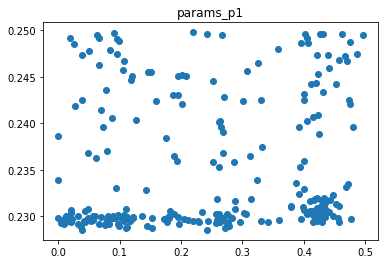

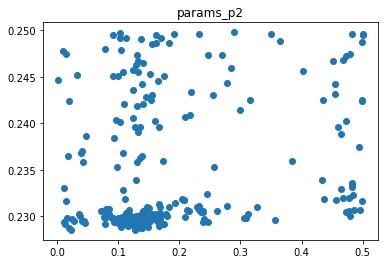

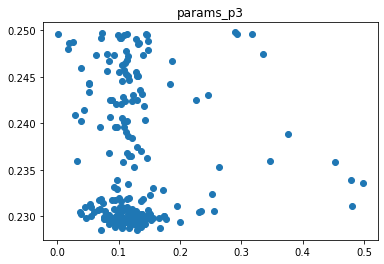

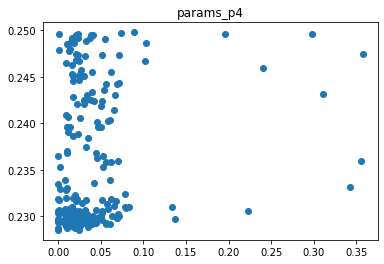

In [23]:
results = results[results.value<.25]
for c in results.columns:
    if c.startswith('params_'):
        results.columns[5].startswith('params')
        plt.title(c)
        plt.scatter(results[c], results.value)
        plt.show()